In [15]:
# 通过深度学习框架的高级API能够使实现Softmax回归变得更加容易
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from IPython import display

In [16]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [17]:
# Softmax回归的输出层是一个全连接层
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10)) # 图像的第一维（channel）保留，其余维度（像素）展平成一维

In [18]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

In [19]:
# 初始化权重值
net.apply(init_weights);

In [20]:
# 在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss(reduction='none')

In [21]:
# 使用学习率为0.1的小批量随机梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [22]:
# 将预测类别与真实y元素进行比较
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [23]:
# 评估任意模型net的准确率
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y), y.numel())
    return metric[0] / metric[1]

In [24]:
# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [25]:
# 定义一个在动画中绘制数据的实用程序类
class Animator:
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale='linear',
                 yscale='linear',fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,figsize=(3.5,2.5)):
        if legend is None:
            legend=[]
        d2l.use_svg_display()
        self.fig,self.axes=d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows*ncols==1:
            self.axes=[self.axes,]
        self.config_axes=lambda:d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X,self.Y,self.fmts=None,None,fmts
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y=[y]
        n=len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        plt.draw()
        plt.pause(0.001)
        display.display(self.fig)
        display.clear_output(wait=True)

In [26]:
# 训练函数
# 开始进行多轮次的训练
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])  # 上文中定义的可视化绘画程序
    for epoch in range(num_epochs):  # 这里体现了训练几轮
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)  # 这里输出的是两个误差
        test_acc = evaluate_accuracy(net, test_iter)  # 这里是在测试数据集test_iter上评估精度
        animator.add(epoch + 1, train_metrics + (test_acc,))  # 在绘图里面显示训练的误差和精度，测试的误差和精度
    train_loss, train_acc = train_metrics
    # assert断言函数是对表达式布尔值的判断，要求表达式计算值必须为真。可用于自动调试。如果表达式为假，触发异常；如果表达式为真，不执行任何操作。
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

<Figure size 640x480 with 0 Axes>

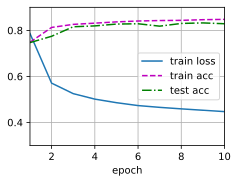

In [27]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)